# Imports

In [273]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Load data

In [274]:
engine = create_engine('sqlite:///../data/project.sqlite', echo=False)

## Load initial data sets

In [275]:
meta_df_all = pd.read_sql("description", engine)
df = pd.read_sql("weather_phenomena", engine)
phenomena_columns = [column for column in df.columns if column.startswith("JA_")]

In [276]:
df[[id_key, time_begin_key, time_end_key, "QN_4"]].head()

,STATIONS_ID,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4
0,1,1949-01-01,1949-12-31,5
1,1,1950-01-01,1950-12-31,5
2,1,1951-01-01,1951-12-31,5
3,1,1952-01-01,1952-12-31,5
4,1,1953-01-01,1953-12-31,5


# Get an overview

In [277]:
df.describe()

,STATIONS_ID,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4,JA_STURM_6,JA_STURM_8,JA_GEWITTER,JA_GLATTEIS,JA_GRAUPEL,JA_HAGEL,JA_NEBEL,JA_TAU
count,34372.000000,34372,34372,34372.000000,34372.00000,34372.000000,34372.000000,34372.000000,34372.000000,34372.000000,34372.000000,34372.000000
mean,3268.012016,1974-03-18 12:46:57.828465040,1975-03-17 18:39:40.449202816,6.649075,-123.46276,-138.679885,-124.731817,-144.211160,-33.840626,-39.795124,-94.736617,-74.116316
min,1.000000,1852-01-01 00:00:00,1852-12-31 00:00:00,1.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,1425.000000,1960-01-01 00:00:00,1960-12-31 00:00:00,5.000000,2.00000,0.000000,12.000000,0.000000,1.000000,0.000000,20.000000,0.000000
50%,3015.000000,1977-01-01 00:00:00,1977-12-31 00:00:00,5.000000,9.00000,0.000000,19.000000,2.000000,4.000000,1.000000,40.000000,75.000000
75%,4496.000000,1993-01-01 00:00:00,1993-12-31 00:00:00,10.000000,23.00000,3.000000,25.000000,6.000000,10.000000,2.000000,62.000000,127.000000
max,19647.000000,2023-01-01 00:00:00,2023-12-31 00:00:00,10.000000,238.00000,227.000000,63.000000,195.000000,117.000000,80.000000,330.000000,299.000000
std,2769.225999,NaN,NaN,3.123737,358.60367,351.484924,357.032686,359.754004,200.826086,199.354034,371.668600,393.361211


In [278]:
len(df.STATIONS_ID.unique())

998

Quality level overview
https://www.dwd.de/DE/leistungen/klimadatendeutschland/qualitaetsniveau.html;jsessionid=B796FC0525BEDEB773E9FC26E2967506.live11043?nn=16102

many values with historical subjective procedures.

missing values haben Wert -999.

# Data filtering

In [279]:
# remove values
df = df[df.QN_4 >= 7]
len(df)

14574

In [280]:
for col in phenomena_columns:
    c = df[col].value_counts(normalize=True)
    print(f"Missing values in {col}: {round(c.loc[-999], 2)}%")

print((df[phenomena_columns] < 0).any(axis=1).value_counts()[True]/len(df))

df = df[(df[phenomena_columns] >= 0).all(axis=1)]

Missing values in JA_STURM_6: 0.02%
Missing values in JA_STURM_8: 0.02%
Missing values in JA_GEWITTER: 0.02%
Missing values in JA_GLATTEIS: 0.02%
Missing values in JA_GRAUPEL: 0.02%
Missing values in JA_HAGEL: 0.02%
Missing values in JA_NEBEL: 0.02%
Missing values in JA_TAU: 0.02%
0.024083985179086043


In [281]:
len(df)

14223

## Check for missing years

In [282]:
id_key = "STATIONS_ID"
time_begin_key = "MESS_DATUM_BEGINN"
time_end_key = "MESS_DATUM_ENDE"

In [289]:
print(df.MESS_DATUM_BEGINN.value_counts().iloc[-10:])

MESS_DATUM_BEGINN
2012-01-01    63
2013-01-01    58
2014-01-01    51
2015-01-01    38
2016-01-01    29
2017-01-01    26
2018-01-01    24
2019-01-01    20
2020-01-01    16
2021-01-01    15
Name: count, dtype: int64


In [288]:
print(df.MESS_DATUM_BEGINN.min())
print(df.MESS_DATUM_ENDE.max())


1981-01-01 00:00:00
2021-12-31 00:00:00


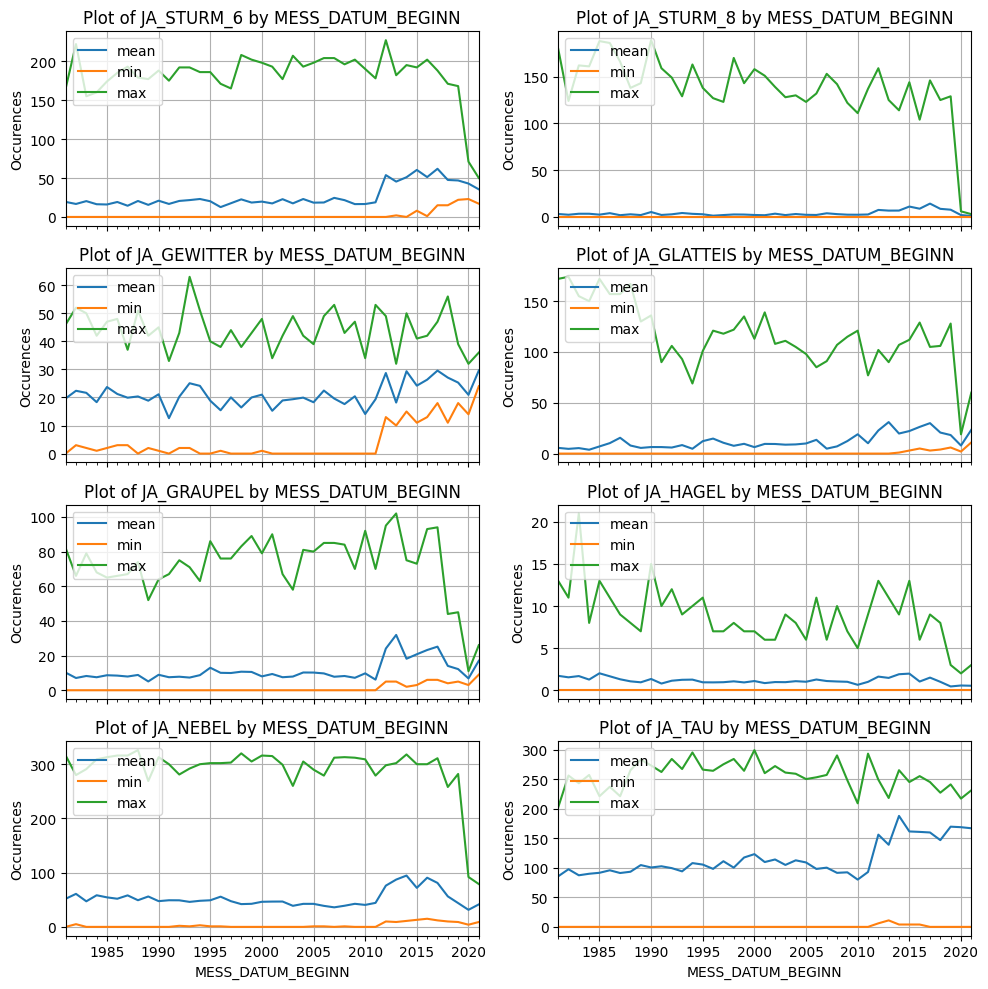

In [298]:

grouped_df = df.groupby(time_begin_key).agg(['mean', 'min', 'max'])
# Number of rows and columns for the subplots grid
nrows = 4
ncols = 2

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column and corresponding axis
for ax, col in zip(axes, phenomena_columns):
    grouped_df[col].plot(ax=ax)
    ax.set_title(f'Plot of {col} by {time_begin_key}')
    ax.set_xlabel(time_begin_key)
    ax.set_ylabel('Occurences')
    ax.legend(loc='upper left')
    ax.grid(True)

# Hide any unused subplots
for i in range(len(phenomena_columns), nrows * ncols):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

    

<Axes: xlabel='MESS_DATUM_BEGINN'>

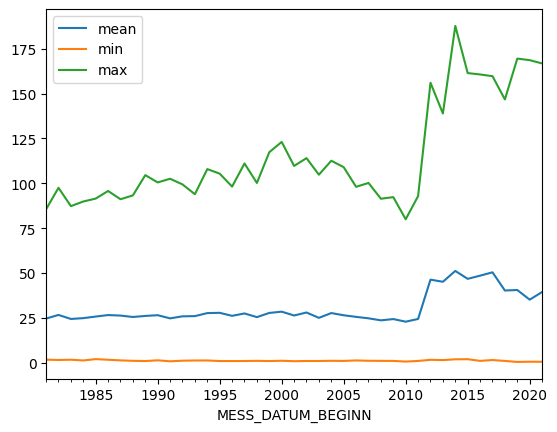

In [299]:
over_all = df.groupby(time_begin_key)[phenomena_columns].mean().agg(['mean', 'min', 'max'], axis=1)
over_all.plot()

#  meta data

In [ ]:
# get meta data to all weather stations with valid data points
merged_df = pd.merge(df, meta_df_all, left_on='STATIONS_ID', right_on='Stations_id', how='left')
meta_df = merged_df[['STATIONS_ID', 'geoBreite', 'geoLaenge', 'Stationshoehe']].drop_duplicates()

In [ ]:
meta_df.head()

,STATIONS_ID,geoBreite,geoLaenge,Stationshoehe
0,1,47.8413,8.8493,478
5,3,50.7827,6.0941,202
35,44,52.9336,8.2370,44
66,52,53.6623,10.1990,46
87,70,48.2052,9.0371,712
